In [2]:
import pandas as pd
from datetime import datetime
import gdown
import sys
import os
import subprocess
import openai
import requests
from dotenv import load_dotenv

load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")

In [3]:
data = {
    'bank': "1dzL_SWBkBs5xrUxuGQTm04oe3USgkL9u",    # banking data
    'sales': "1QK-VgSU3AxXUw330KjYFUj8S9hzKJsG6",   # sales data
    'mcc': "1JN0bR84sgZ_o4wjKPBUmz45NeEEkVgt7",     # mcc description
}

# Download all files from Google Drive
for name, file_id in data.items():
    gdown.download(f'https://drive.google.com/uc?id={file_id}', name + '.parquet', quiet=False)
    
# Read all files and store on a dictionary of pandas dataframes
df = {} 
for name in data.keys():
    df[name] = pd.read_parquet(name + '.parquet')
    

Downloading...
From: https://drive.google.com/uc?id=1dzL_SWBkBs5xrUxuGQTm04oe3USgkL9u
To: /Users/riley/VSCode/HackBRASA/backend/bank.parquet
100%|██████████| 1.57M/1.57M [00:00<00:00, 7.65MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QK-VgSU3AxXUw330KjYFUj8S9hzKJsG6
To: /Users/riley/VSCode/HackBRASA/backend/sales.parquet
100%|██████████| 6.37M/6.37M [00:00<00:00, 21.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JN0bR84sgZ_o4wjKPBUmz45NeEEkVgt7
To: /Users/riley/VSCode/HackBRASA/backend/mcc.parquet
100%|██████████| 57.3k/57.3k [00:00<00:00, 1.18MB/s]


In [17]:
# Useful Functions
def display_head_with_scroll(df, num_rows=5):
    """
    Display a DataFrame with horizontal scrolling enabled.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to display.
    num_rows (int): The number of rows to display. Default is 5.
    """
    display(HTML(scrolling_css + df.head(num_rows).to_html(classes='dataframe-div')))

def require(package):
    try:
        # Try to import the package
        globals()[package] = __import__(package)
        return True
    except ImportError:
        print(f"{package} is not installed. Trying to install via Homebrew...")
        try:
            # Attempt to install the package using Homebrew
            subprocess.check_call(["brew", "install", package])
            # After installation, try importing again
            globals()[package] = __import__(package)
            return True
        except subprocess.CalledProcessError:
            print(f"Failed to install {package} via Homebrew. Trying pip with --break-system-packages...")
            try:
                # If Homebrew fails, try installing via pip with the break-system-packages flag
                subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--break-system-packages"])
                globals()[package] = __import__(package)
                return True
            except ImportError:
                print(f"Failed to install {package}.")
                return False
            
import requests

# Replace with your OpenAI API key


# Initialize global variables
newprompt = ""
output = ""
total_tokens_used = 0
cost = 0.0

def openai_prompting(prompt):
    global newprompt
    global output
    global total_tokens_used
    global cost
    print("\n\nRunning GPT-3.5")

    # Define the endpoint URL
    url = "https://api.openai.com/v1/chat/completions"

    # Set up the request headers with your API key
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai.api_key}"
    }

    # Define the request payload (input text and parameters)
    data = {
        "model": "gpt-3.5-turbo",  # choose the model
        "messages": [{"role": "system", "content": "You are a data scientist with the goal of analyzing the data in response to the users prompt. The data, stored in df['sales], contains information about sales"
                      " data and has been preprocessed already such that it has df['sales'].shape of (264933, 7), df['sales'].columns.tolist() of ['document_id', 'date_time', 'value', 'card_number', 'type', 'mcc', 'state'],"
                      " and df['sales'].dtypes.tolist() of [dtype('int64'), dtype('<M8[us]'), dtype('float64'), dtype('O'), dtype('O'), dtype('int64'), dtype('O')]. Please make sure to return only python code that is executable"
                      "for querying the data. You can use numpy, pandas, or plotly to complete the task in response to the users prompt. I have attached the first row of the data as an example. The code should output the answer to the user"
                      " in the simplest manner possible such as an integer with a $. Also, when a plot is requested make sure the plot is displayed in the output with axis that are scaled to a reasonable level. For example,"
                      "if the user asks for sales in the year of 2023 it would make sense to bin the data by week rather than plotting every single day on the x-axis. Be sure to use the data stored in df['sales]."},  # system message
                      {"role": "user", "content": f"{prompt}"}],  # prompt here
        "max_tokens": 800  # maximum number of tokens for the model
    }
    if prompt != "":
        newprompt = prompt
        response = requests.post(url, json=data, headers=headers)
    else:
        print("You have an empty prompt, so printing the previous prompt again or default if first prompt is empty.\n")
        print(f"Prompt: {newprompt}")
        print(f"\nOutput: {output}")
        print("\nTokens Used: " + str(total_tokens_used))
        print("Cost: $" + format(cost, ".8f").rstrip("0").rstrip("."))
        return

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Parse response to get the text and number of tokens
        output = response.json()['choices'][0]['message']['content']
        output = output.strip().replace("\n\n", "\n")
        prompt_tokens_used = response.json()['usage']['prompt_tokens']
        completion_tokens_used = response.json()['usage']['completion_tokens']
        total_tokens_used = response.json()['usage']['total_tokens']
        
        # Pricing based on gpt-3.5-turbo
        cost_per_input_token = 0.002 / 1_000  # $0.002 per 1,000 tokens for inputs
        cost_per_output_token = 0.002 / 1_000  # $0.002 per 1,000 tokens for outputs
        cost = prompt_tokens_used * cost_per_input_token + completion_tokens_used * cost_per_output_token

        # Print the completion text, tokens used, and cost
        print(f"Prompt: {newprompt}")
        print(f"\nOutput: {output}")
        print("\nTokens Used: " + str(total_tokens_used))
        print("Cost: $" + format(cost, ".8f").rstrip("0").rstrip("."))
        return output
    else:
        # Print error message if request was not successful
        print("Error:", response.text)


In [7]:
# Preprocess the sales data
df['sales']['date_time'] = pd.to_datetime(df['sales']['date_time'])  # Convert to datetime
df['sales']['day_of_week'] = df['sales']['date_time'].dt.day_name()  # Extract day of the week
df['sales']['hour'] = df['sales']['date_time'].dt.hour              # Extract hour of the day

In [24]:
# Define the user query
user_query = "generate a bar chart of the sales over time in 2023?"

# Extract the first five rows of df['sales'] as an example to include in the prompt
sample_data = df['sales'].head(1).to_string(index=False)

# Ask the model to generate a prompt that includes the user query and lets it know about the data
generation_prompt = f"""
Given the following user query:

'{user_query}'

Please generate a prompt that includes the necessary instructions and informs the model that it will be expected to analyze the data. The data will be provided, and you can assume that the data is in a Pandas DataFrame. Below are the first five rows of the DataFrame that will be used for analysis:

{sample_data}

Please generate a prompt that explains what the model should do based on the user's query and the data provided.
"""

# Send the request to OpenAI to generate the prompt
response_text = openai_prompting(user_query)

# Extract the generated prompt
print("Generated Prompt:\n\n", output)



Running GPT-3.5
Prompt: generate a bar chart of the sales over time in 2023?

Output: ```python
import pandas as pd
import matplotlib.pyplot as plt
# Convert 'date_time' column to datetime format
df['sales']['date_time'] = pd.to_datetime(df['sales']['date_time'])
# Filter data for the year 2023
sales_2023 = df['sales'][df['sales']['date_time'].dt.year == 2023]
# Group by week and sum the 'value' column
sales_over_time_2023 = sales_2023.resample('W', on='date_time')['value'].sum()
# Generate bar chart
sales_over_time_2023.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Week in 2023')
plt.ylabel('Total Sales')
plt.title('Sales over time in 2023')
plt.show()
```

Tokens Used: 473
Cost: $0.000946
Generated Prompt:

 ```python
import pandas as pd
import matplotlib.pyplot as plt
# Convert 'date_time' column to datetime format
df['sales']['date_time'] = pd.to_datetime(df['sales']['date_time'])
# Filter data for the year 2023
sales_2023 = df['sales'][df['sales']['date_time'].dt.year == 2023]
#

In [25]:
print(output)

```python
import pandas as pd
import matplotlib.pyplot as plt
# Convert 'date_time' column to datetime format
df['sales']['date_time'] = pd.to_datetime(df['sales']['date_time'])
# Filter data for the year 2023
sales_2023 = df['sales'][df['sales']['date_time'].dt.year == 2023]
# Group by week and sum the 'value' column
sales_over_time_2023 = sales_2023.resample('W', on='date_time')['value'].sum()
# Generate bar chart
sales_over_time_2023.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Week in 2023')
plt.ylabel('Total Sales')
plt.title('Sales over time in 2023')
plt.show()
```


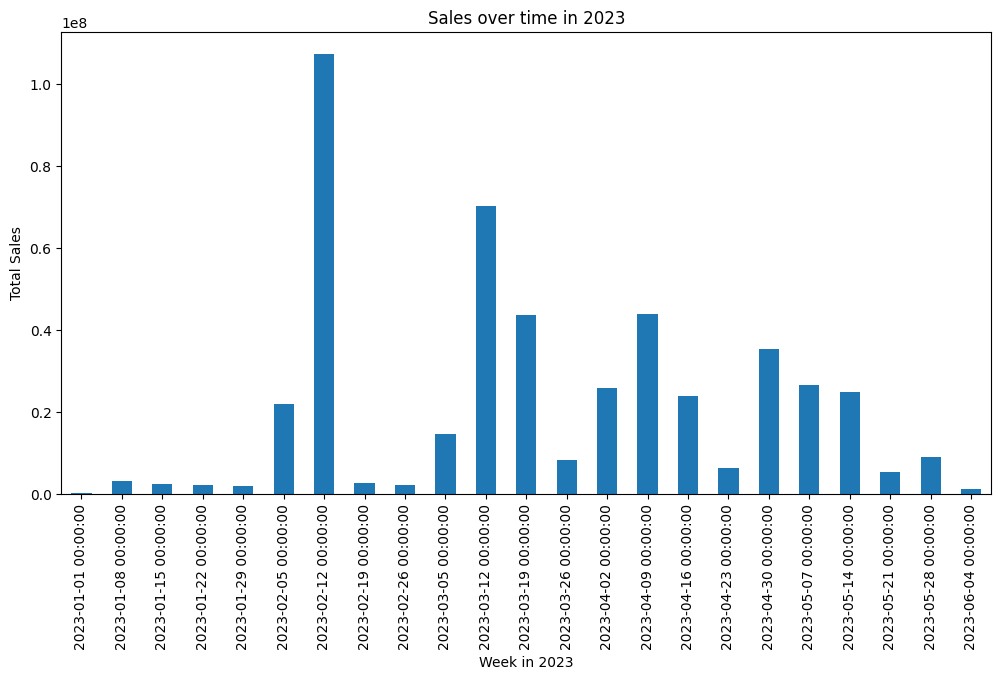

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
# Convert 'date_time' column to datetime format
df['sales']['date_time'] = pd.to_datetime(df['sales']['date_time'])
# Filter data for the year 2023
sales_2023 = df['sales'][df['sales']['date_time'].dt.year == 2023]
# Group by week and sum the 'value' column
sales_over_time_2023 = sales_2023.resample('W', on='date_time')['value'].sum()
# Generate bar chart
sales_over_time_2023.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Week in 2023')
plt.ylabel('Total Sales')
plt.title('Sales over time in 2023')
plt.show()

Executing the following code:

import pandas as pd
import matplotlib.pyplot as plt
# Convert 'date_time' column to datetime format
df['sales']['date_time'] = pd.to_datetime(df['sales']['date_time'])
# Filter data for the year 2023
sales_2023 = df['sales'][df['sales']['date_time'].dt.year == 2023]
# Group by week and sum the 'value' column
sales_over_time_2023 = sales_2023.resample('W', on='date_time')['value'].sum()
# Generate bar chart
sales_over_time_2023.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Week in 2023')
plt.ylabel('Total Sales')
plt.title('Sales over time in 2023')
plt.show()


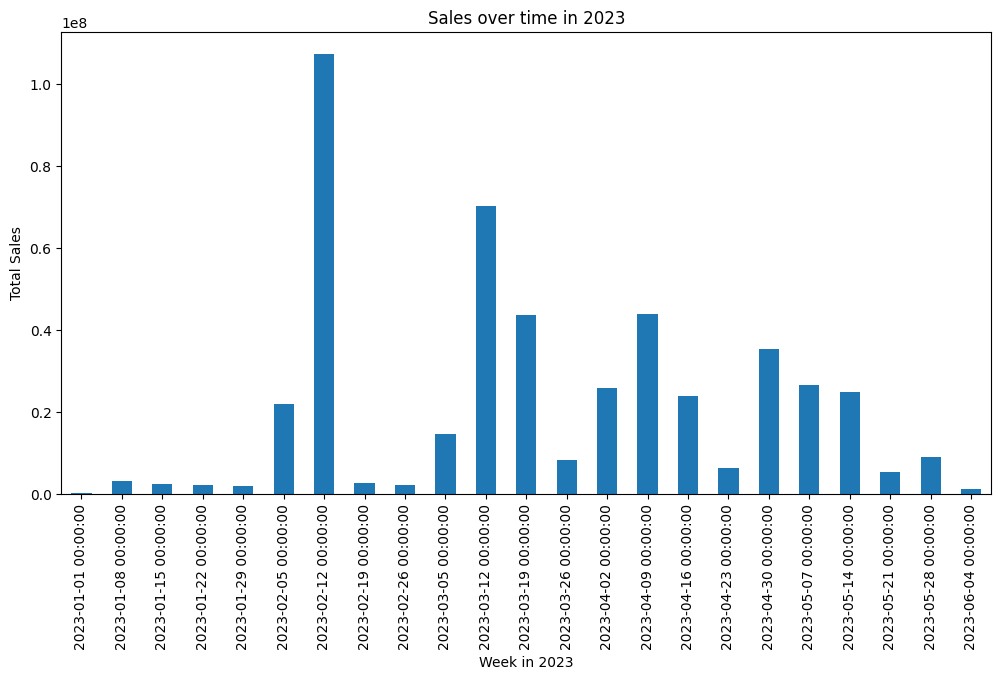

In [27]:
# Remove unnecessary markdown formatting
output = output.replace("```python\n", "").replace("\n```", "")

# Prepare a dictionary to capture the local variables
local_vars = {}

# Split the output into lines and join them
lines = output.strip().split('\n')
joined_lines = "\n".join(lines)

# Debug: Print the joined lines before execution
print("Executing the following code:\n")
print(joined_lines)

# Execute the code and capture the local variables
exec(joined_lines, globals(), local_vars)

if 'plt.show()' in joined_lines:
    plt.show()
else:
    # Get the last variable name and value
    last_var_name = list(local_vars.keys())[-1]
    last_var_value = local_vars[last_var_name]

    # Format the result based on its type
    if isinstance(last_var_value, (int, float)):
        formatted_result = "\n\nResult: ${:,.2f}".format(last_var_value)
    elif isinstance(last_var_value, pd.Series):
        formatted_result = "\n\nResult:\n" + last_var_value.round(2).apply(lambda x: f"{x:.2f}%").to_string()
    else:
        formatted_result = "\n\nResult:\n" + str(last_var_value)
    print(formatted_result)

In [109]:
last_var_value

type
Débito         57.525821
Crédito        34.915905
Pix             6.829933
Refeição        0.360250
Voucher         0.239586
Alimentação     0.110645
Benefícios      0.013504
Flex            0.004356
Name: proportion, dtype: float64